In [1]:
#get all libs for time series analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error


In [2]:
# Import data from parquet file
df = pd.read_parquet('/Users/paddy/Documents/GitHub/Masterthesis_ML/data/02_timeseries_zone70.parquet')

# # Convert the date column to datetime
df['date'] = pd.to_datetime(df['tpep_pickup_datetime'])


In [3]:
print(df.head())

       tpep_pickup_datetime  PULocationID                      date
0 2022-04-01 00:06:11+00:00            70 2022-04-01 00:06:11+00:00
1 2022-04-01 00:09:33+00:00            70 2022-04-01 00:09:33+00:00
2 2022-04-01 00:10:28+00:00            70 2022-04-01 00:10:28+00:00
3 2022-04-01 00:11:45+00:00            70 2022-04-01 00:11:45+00:00
4 2022-04-01 00:11:46+00:00            70 2022-04-01 00:11:46+00:00


***1 day data***

In [4]:
# making intervals of 1 day
df_1day = (pd.to_datetime(df['tpep_pickup_datetime'], unit='H')
    .dt.floor('24H') 
    .value_counts()
    .rename_axis('date')
    .reset_index(name='rides')
)
# sort by date
df_1day = df_1day.sort_values(by='date')

In [5]:
#### Data preparation
# define weekdays columns with name of the weekday and 0 or 1
df_1day['weekday'] = df_1day['date'].dt.day_name()
#week of year
df_1day['week_of_year'] = df_1day['date'].dt.isocalendar().week
#day of week
df_1day['day_of_week'] = df_1day['date'].dt.day_of_week
# Weekdays: Monday(0) to Friday(4), Weekends: Saturday(5) and Sunday(6)
df_1day['weekday_or_weekend'] = df_1day['day_of_week'].apply(lambda x: 'Weekday' if x < 5 else 'Weekend')


print(df_1day.head(5))


                         date  rides   weekday  week_of_year  day_of_week  \
251 2022-04-01 00:00:00+00:00    398    Friday            13            4   
252 2022-04-02 00:00:00+00:00    397  Saturday            13            5   
225 2022-04-03 00:00:00+00:00    410    Sunday            13            6   
192 2022-04-04 00:00:00+00:00    433    Monday            14            0   
128 2022-04-05 00:00:00+00:00    471   Tuesday            14            1   

    weekday_or_weekend  
251            Weekday  
252            Weekend  
225            Weekend  
192            Weekday  
128            Weekday  


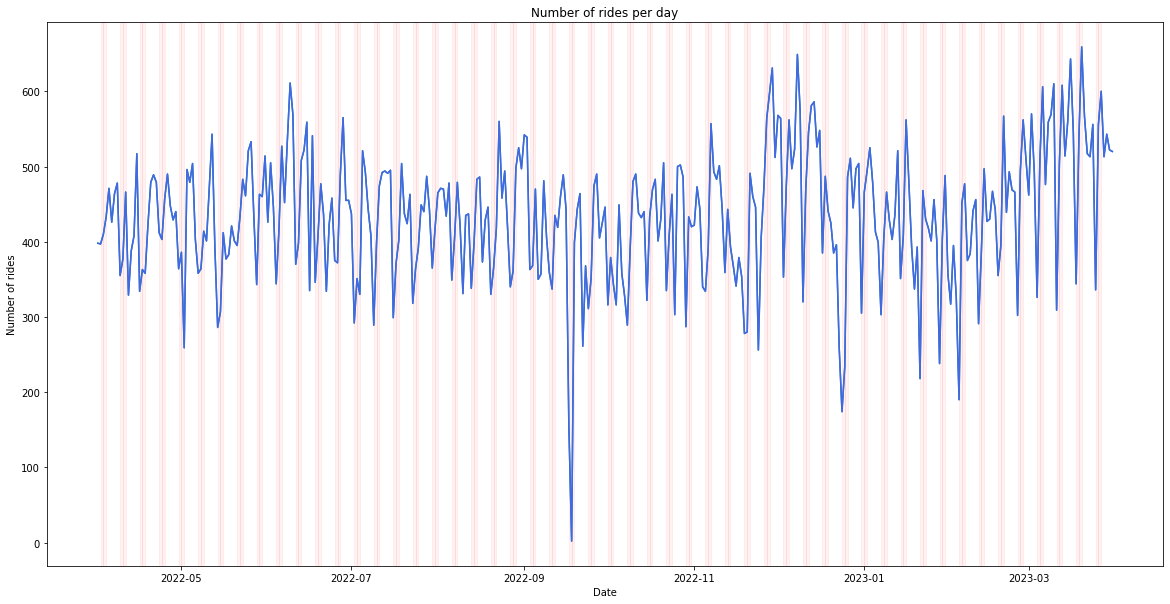

In [6]:
# get data of weekends from the data in df_1day
df_1day_weekend = df_1day[df_1day['date'].dt.dayofweek > 4]

# plot the data
plt.figure(figsize=(20,10))


plt.plot(df_1day['date'], df_1day['rides'])
plt.title('Number of rides per day')
plt.xlabel('Date')
plt.ylabel('Number of rides')
# set color of line to royal blue
plt.plot(df_1day['date'], df_1day['rides'], color='royalblue')
# make the weekends red

for i in range(len(df_1day_weekend)):
    plt.axvspan(df_1day_weekend.iloc[i]['date'], df_1day_weekend.iloc[i]['date'] + pd.Timedelta(days=1), color='red', alpha=0.05)


# save the plot
plt.savefig('/Users/paddy/Documents/GitHub/Masterthesis_ML/plots/02_24H_zone70.png', dpi=300, bbox_inches='tight')

plt.show()

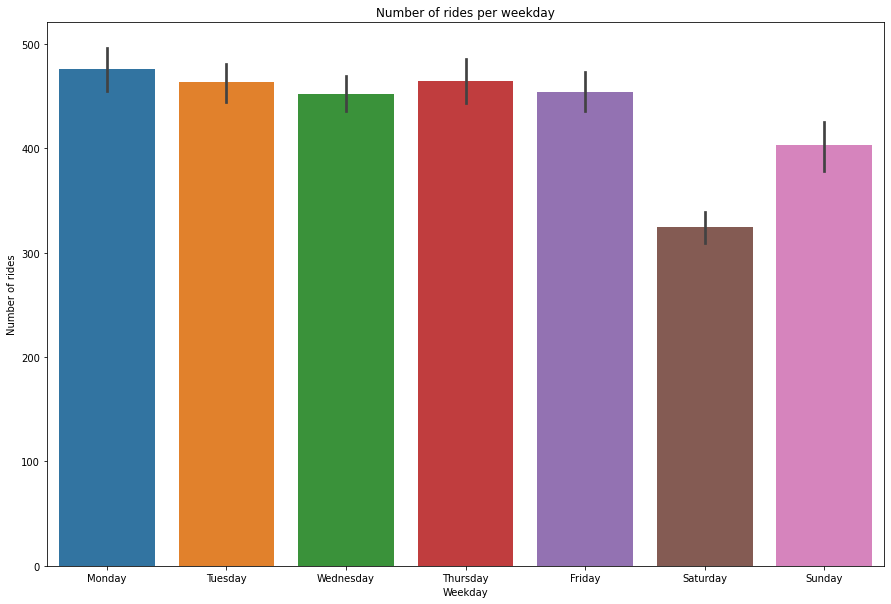

In [7]:
#plot a bar chart with the number of rides per weekday
plt.figure(figsize=(15,10))
sns.barplot(x='weekday', y='rides', data=df_1day, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Number of rides per weekday')
plt.xlabel('Weekday')
plt.ylabel('Number of rides')

# save the plot
plt.savefig('/Users/paddy/Documents/GitHub/Masterthesis_ML/plots/02_weekdays_zone70.png', dpi=300, bbox_inches='tight')

plt.show()

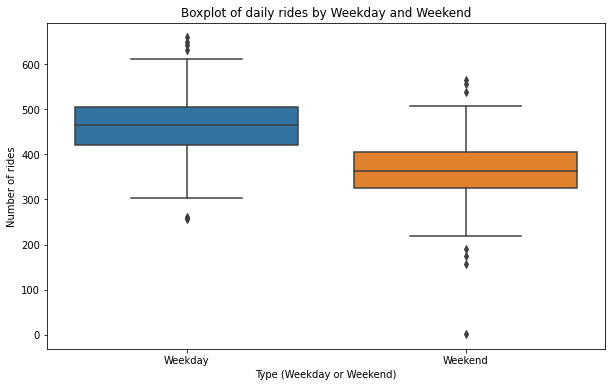

In [8]:
# Prepare data for the boxplot
df_box = df_1day.copy()
df_box['date'] = df_1day['date'].dt.date

#gruppiere nach weekday_or_weekend und summiere die rides
daily_counts_weekday_weekend = df_box.groupby(['weekday_or_weekend', 'date']).sum().reset_index()

# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='weekday_or_weekend', y='rides', data=daily_counts_weekday_weekend) 

plt.title('Boxplot of daily rides by Weekday and Weekend')
plt.xlabel('Type (Weekday or Weekend)')
plt.ylabel('Number of rides')
# make color of weekdays royalblue

#save the plot
plt.savefig('/Users/paddy/Documents/GitHub/Masterthesis_ML/plots/02_boxplot_zone70.png', dpi=300, bbox_inches='tight')

plt.show()


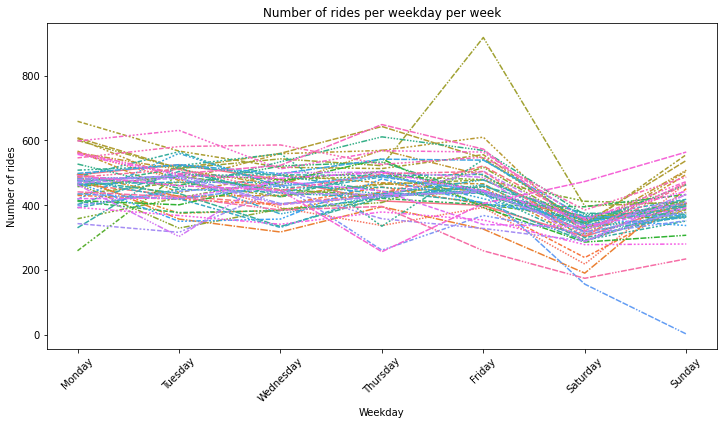

In [9]:
df_development = df_1day.copy()

df_development['date'] = pd.to_datetime(df_development['date'])

plot_data = df_development.groupby(['week_of_year', 'day_of_week'])['rides'].sum().unstack()

plt.figure(figsize=(12, 6))
sns.lineplot(data=plot_data.T)
# title in english
plt.title('Number of rides per weekday per week')
plt.xlabel('Weekday')
plt.ylabel('Number of rides') # in en
plt.xticks(rotation=45)

#sort weekdays in english with monday first = 0 and sunday last = 6
#plt.gca().set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

#count the ticklabels on x-axis
x_ticks = np.arange(0, 7, 1)
#set the ticklabels on x-axis
plt.xticks(x_ticks, ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])


#delete the week legend
plt.legend().remove()

#save the plot
plt.savefig('/Users/paddy/Documents/GitHub/Masterthesis_ML/plots/02_weekly_development_zone70.png', dpi=300, bbox_inches='tight')

plt.show()


In [10]:
#print the data as table as csv
print(plot_data.T.to_csv('/Users/paddy/Documents/GitHub/Masterthesis_ML/plots/02_weekly_development_zone70.csv'))



None


**1 hour data**

In [11]:
# making intervals of 60 minutes
df_60min = (pd.to_datetime(df['tpep_pickup_datetime'], unit='H')
    .dt.floor('1H') 
    .value_counts()
    .rename_axis('date')
    .reset_index(name='rides')
)
# sort by date
df_60min = df_60min.sort_values(by='date')

print(df_60min.head(5))


                          date  rides
2685 2022-04-01 00:00:00+00:00     26
4926 2022-04-01 01:00:00+00:00     15
6309 2022-04-01 02:00:00+00:00      5
6848 2022-04-01 03:00:00+00:00      1
6871 2022-04-01 04:00:00+00:00      1


In [12]:
### Data preparation

# Extract the hour of the day from the datetime
df_60min['hour_of_day'] = df_60min['date'].dt.hour
# Extract the day of the week from the datetime
df_60min['day_of_week'] = df_60min['date'].dt.dayofweek
# Extract day names from the datetime
df_60min['day_names'] = df_60min['date'].dt.day_name()

# sum up the rides for each hour of the day
hourly_counts = df_60min.groupby('hour_of_day')['rides'].sum()

print(df_60min.head(5))

                          date  rides  hour_of_day  day_of_week day_names
2685 2022-04-01 00:00:00+00:00     26            0            4    Friday
4926 2022-04-01 01:00:00+00:00     15            1            4    Friday
6309 2022-04-01 02:00:00+00:00      5            2            4    Friday
6848 2022-04-01 03:00:00+00:00      1            3            4    Friday
6871 2022-04-01 04:00:00+00:00      1            4            4    Friday


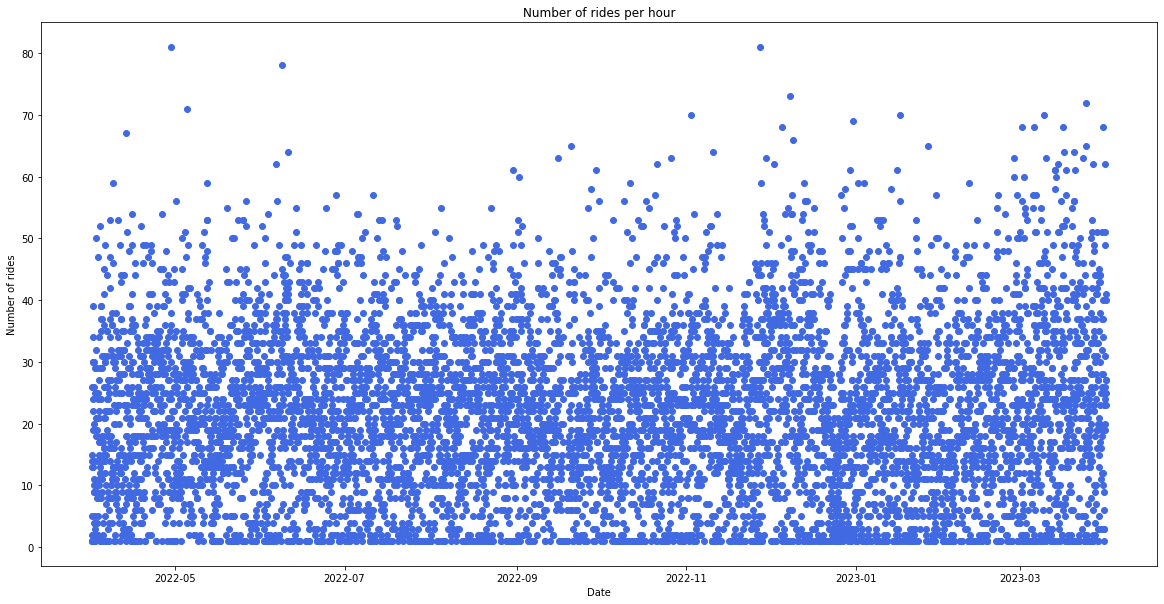

In [13]:
# plot 60 min data
plt.figure(figsize=(20,10))
#plot as dots
plt.title('Number of rides per hour')
plt.xlabel('Date')
plt.ylabel('Number of rides')
# set color of line to royal blue
plt.scatter(df_60min['date'], df_60min['rides'], color='royalblue')

# save the plot
plt.savefig('/Users/paddy/Documents/GitHub/Masterthesis_ML/plots/02_60min_zone70.png', dpi=300, bbox_inches='tight')

plt.show()

In [14]:
# Plot the trend analysis for

In [15]:
# Create a pivot table for the heatmap with sum of rides
pivot_table = df_60min.pivot_table(index='day_of_week', columns='hour_of_day', values='rides', aggfunc='sum')

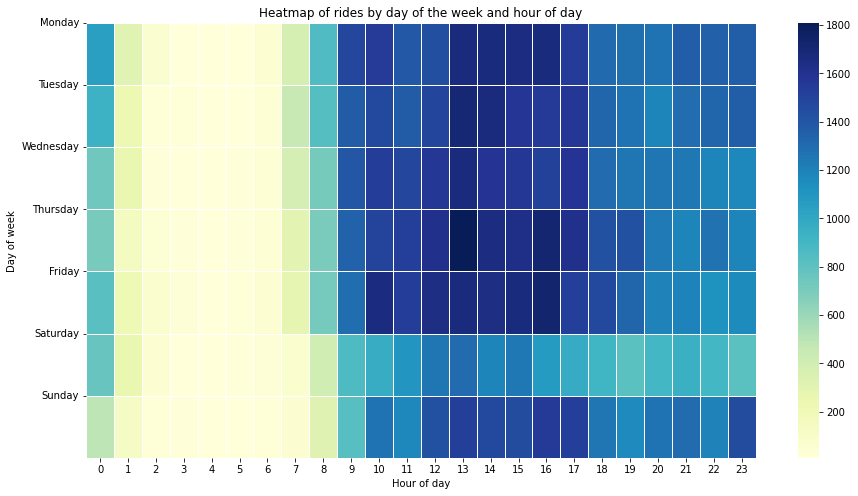

In [16]:
# Create a heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(pivot_table, cmap="YlGnBu", linewidths=.5)
plt.title('Heatmap of rides by day of the week and hour of day')
plt.xlabel('Hour of day')
plt.ylabel('Day of week')
plt.yticks(ticks=range(0, 7), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=0)
plt.xticks(rotation=0)
#set legend to max value

#save the plot
plt.savefig('/Users/paddy/Documents/GitHub/Masterthesis_ML/plots/02_heatmap_hourly_zone70.png', dpi=300, bbox_inches='tight')

plt.show()


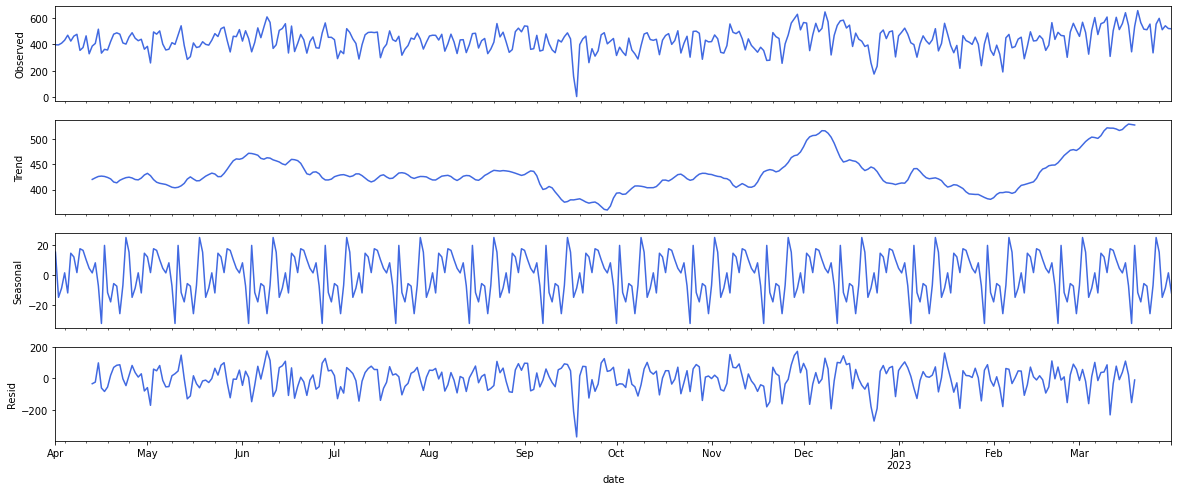

In [19]:
# Decompose the time series
df_decompose = df_1day.copy()
df_decompose = df_decompose.set_index('date')

# Decompose the time series
decomposition = seasonal_decompose(df_decompose['rides'], model='additive', period=24)

# Plot the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12,8))
decomposition.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')
decomposition.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')
decomposition.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')
decomposition.resid.plot(ax=ax4)
ax4.set_ylabel('Resid')

# delete x-axis label and ticks
ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')
ax1.set_xticks([])
ax2.set_xticks([])
ax3.set_xticks([])

#make plot bigger
plt.gcf().set_size_inches(20, 8)
# color of the lines royal blue
ax1.lines[0].set_color('royalblue')
ax2.lines[0].set_color('royalblue')
ax3.lines[0].set_color('royalblue')
ax4.lines[0].set_color('royalblue')

#save the plot
plt.savefig('/Users/paddy/Documents/GitHub/Masterthesis_ML/plots/02_decomposition_zone70.png', dpi=300, bbox_inches='tight')

plt.show()